In [1]:
# imports
from __future__ import division, print_function
%matplotlib inline

from qinfer import *
import os, sys
import pathlib
from importlib import reload
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
try:
    plt.style.use('ggplot-rq')
except IOError:
    try:
        plt.style.use('ggplot')
    except:
        raise RuntimeError('Cannot set the style. Likely cause is out of date matplotlib; >= 1.4 required.')

In [3]:
# For local package imports
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [4]:
import bayesianhl

# 1. Single Interaction Example

In [5]:
from bayesianhl.qinfer_system_models import SingleInteractionModel

## 1.1 Learning sequentially from measurements

In [6]:
sys_model = SingleInteractionModel()
prior = UniformDistribution([0, 1])
updater = SMCUpdater(sys_model, 2000, prior)

In [7]:
sys_model.Q

array([1.])

In [8]:
# True model
true_params = np.array([[0.3]])

In [9]:
# Parameters of experiment
tvec = np.linspace(0, 60, 200)
n_shots = 100

In [10]:
# One shot at a time
est_hist = []
for t in tvec:
    for n in range(n_shots):
        #experiment = np.array([(t, n_shots)], dtype=sys_model.expparams_dtype)
        experiment = np.array([t], dtype=sys_model.expparams_dtype)
        datum = sys_model.simulate_experiment(true_params, experiment)
        updater.update(datum, experiment)
    
    est_hist.append(updater.est_mean())

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  


Text(0, 0.5, '$\\omega$')

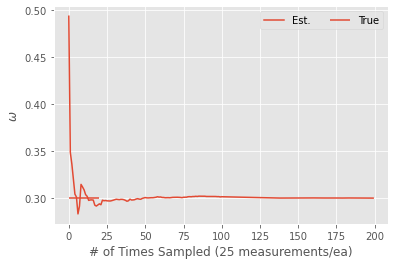

In [11]:
plt.plot(est_hist, label='Est.')
plt.hlines(true_params, 0, 20, label='True')
plt.legend(ncol=2)
plt.xlabel('# of Times Sampled (25 measurements/ea)')
plt.ylabel(r'$\omega$')

In [12]:
updater.est_mean()

array([0.29971437])

In [13]:
# Look at the internals of the SMCUpdater a bit more
# Current query and measurement outcome
print(experiment)
print(datum)

# Set results from above query and measurement outcome
outcomes = datum
expparams = experiment

# Taken from the hypothetical_update method in the smc code
weights = updater.particle_weights
locs = updater.particle_locations

# Check if we have a single outcome or an array. If we only have one
# outcome, wrap it in a one-index array.
if not isinstance(outcomes, np.ndarray):
    outcomes = np.array([outcomes])

# update the weights sans normalization
# Rearrange so that likelihoods have shape (outcomes, experiments, models).
# This makes the multiplication with weights (shape (models,)) make sense,
# since NumPy broadcasting rules align on the right-most index.
L = updater.model.likelihood(outcomes, locs, expparams).transpose([0, 2, 1])
hyp_weights = weights * L

[(60.,)]
1


## 2.2 Multiple shots at a time

In [15]:
sys_model = BinomialModel(SingleInteractionModel())
prior = UniformDistribution([0, 1])
updater = SMCUpdater(sys_model, 2000, prior)

In [16]:
# True model
true_params = np.array([[0.3]])

In [17]:
t = 15
n_shots = 50

experiment = np.array([(t, n_shots)], dtype=sys_model.expparams_dtype)
outcomes = sys_model.simulate_experiment(true_params, experiment)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  after removing the cwd from sys.path.


In [18]:
outcomes

25

In [19]:
print(updater.resample_count)

0


In [20]:
# Multiple shots at each t
est_hist = []
resampling_hist = []
for t in tvec:
    experiment = np.array([(t, n_shots)], dtype=sys_model.expparams_dtype)
    outcomes = sys_model.simulate_experiment(true_params, experiment)
    updater.update(outcomes, experiment)
    
    est_hist.append(updater.est_mean())
    resampling_hist.append(updater.resample_count)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  """


Text(0, 0.5, '$\\omega$')

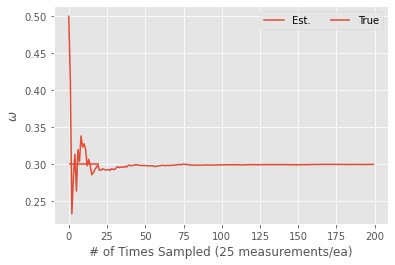

In [21]:
plt.plot(est_hist, label='Est.')
plt.hlines(true_params, 0, 20, label='True')
plt.legend(ncol=2)
plt.xlabel('# of Times Sampled (25 measurements/ea)')
plt.ylabel(r'$\omega$')

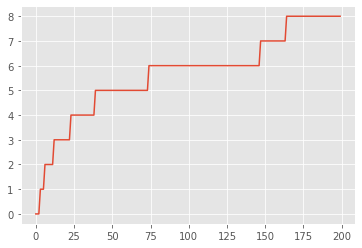

In [22]:
plt.plot(resampling_hist)

In [23]:
print(updater.resample_count)

8


In [24]:
updater.est_mean()

array([0.29970025])

In [25]:
# Let's see the computational cost associated with this -- measured in terms of number of likelihood calls
# Current query and measurement outcome
print(experiment)
print(outcomes)

# Set results from above query and measurement outcome
expparams = experiment

# Taken from the hypothetical_update method in the smc code
weights = updater.particle_weights
locs = updater.particle_locations

# Check if we have a single outcome or an array. If we only have one
# outcome, wrap it in a one-index array.
if not isinstance(outcomes, np.ndarray):
    outcomes = np.array([outcomes])

# update the weights sans normalization
# Rearrange so that likelihoods have shape (outcomes, experiments, models).
# This makes the multiplication with weights (shape (models,)) make sense,
# since NumPy broadcasting rules align on the right-most index.
L = updater.model.likelihood(outcomes, locs, expparams).transpose([0, 2, 1])
hyp_weights = weights * L

[(60., 50)]
10


In [26]:
L.shape

(1, 1, 2000)

In [27]:
updater.resample_count

8

# 2. Simplified CR Hamiltonian

In [28]:
from bayesianhl.qinfer_system_models import SimplifiedCRHamiltonian

## 2.1 Multiple shots, single experiment at a time, no non-dim

In [29]:
child_sys_model = SimplifiedCRHamiltonian()

In [30]:
child_sys_model.Q

array([1., 1., 1.])

In [31]:
sys_model = BinomialModel(SimplifiedCRHamiltonian())

In [32]:
# Set truth
true_params = np.array([[0.3, 0.35, 0.375]])

In [33]:
# Process one experiment, multiple shots
mop = 0
uop = 1
t = 0.1
n_shots = 100

experiment = np.array([(mop, uop, t, n_shots)], dtype=sys_model.expparams_dtype)
outcomes = sys_model.simulate_experiment(true_params, experiment)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  import sys


In [34]:
# Lets try this with an estimator
prior = UniformDistribution([[0, 1]]*3)
updater = SMCUpdater(sys_model, 2000, prior)

In [35]:
# Define experiments
tvec = np.linspace(0.1, 0.6, 81)
mvec = [0, 1, 2]
uvec = [0, 1]

In [36]:
# Multiple shots at each (M, U, t)
est_hist = []
cum_shots = []

cum_shots_counter = 0
for t in tvec:
    for m in mvec:
        for u in uvec:
            experiment = np.array([(m, u, t, n_shots)], dtype=sys_model.expparams_dtype)
            outcomes = sys_model.simulate_experiment(true_params, experiment)
            updater.update(outcomes, experiment)
            
            cum_shots_counter += n_shots
    
            print('Done with (m,u,t) = (%d, %d, %f)' %(m, u, t))
    
    est_hist.append(updater.est_mean())
    cum_shots.append(cum_shots_counter)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if __name__ == '__main__':


Done with (m,u,t) = (0, 0, 0.100000)
Done with (m,u,t) = (0, 1, 0.100000)
Done with (m,u,t) = (1, 0, 0.100000)
Done with (m,u,t) = (1, 1, 0.100000)
Done with (m,u,t) = (2, 0, 0.100000)
Done with (m,u,t) = (2, 1, 0.100000)
Done with (m,u,t) = (0, 0, 0.106250)
Done with (m,u,t) = (0, 1, 0.106250)
Done with (m,u,t) = (1, 0, 0.106250)
Done with (m,u,t) = (1, 1, 0.106250)
Done with (m,u,t) = (2, 0, 0.106250)
Done with (m,u,t) = (2, 1, 0.106250)
Done with (m,u,t) = (0, 0, 0.112500)
Done with (m,u,t) = (0, 1, 0.112500)
Done with (m,u,t) = (1, 0, 0.112500)
Done with (m,u,t) = (1, 1, 0.112500)
Done with (m,u,t) = (2, 0, 0.112500)
Done with (m,u,t) = (2, 1, 0.112500)
Done with (m,u,t) = (0, 0, 0.118750)
Done with (m,u,t) = (0, 1, 0.118750)
Done with (m,u,t) = (1, 0, 0.118750)
Done with (m,u,t) = (1, 1, 0.118750)
Done with (m,u,t) = (2, 0, 0.118750)
Done with (m,u,t) = (2, 1, 0.118750)
Done with (m,u,t) = (0, 0, 0.125000)
Done with (m,u,t) = (0, 1, 0.125000)
Done with (m,u,t) = (1, 0, 0.125000)
D

Done with (m,u,t) = (2, 0, 0.393750)
Done with (m,u,t) = (2, 1, 0.393750)
Done with (m,u,t) = (0, 0, 0.400000)
Done with (m,u,t) = (0, 1, 0.400000)
Done with (m,u,t) = (1, 0, 0.400000)
Done with (m,u,t) = (1, 1, 0.400000)
Done with (m,u,t) = (2, 0, 0.400000)
Done with (m,u,t) = (2, 1, 0.400000)
Done with (m,u,t) = (0, 0, 0.406250)
Done with (m,u,t) = (0, 1, 0.406250)
Done with (m,u,t) = (1, 0, 0.406250)
Done with (m,u,t) = (1, 1, 0.406250)
Done with (m,u,t) = (2, 0, 0.406250)
Done with (m,u,t) = (2, 1, 0.406250)
Done with (m,u,t) = (0, 0, 0.412500)
Done with (m,u,t) = (0, 1, 0.412500)
Done with (m,u,t) = (1, 0, 0.412500)
Done with (m,u,t) = (1, 1, 0.412500)
Done with (m,u,t) = (2, 0, 0.412500)
Done with (m,u,t) = (2, 1, 0.412500)
Done with (m,u,t) = (0, 0, 0.418750)
Done with (m,u,t) = (0, 1, 0.418750)
Done with (m,u,t) = (1, 0, 0.418750)
Done with (m,u,t) = (1, 1, 0.418750)
Done with (m,u,t) = (2, 0, 0.418750)
Done with (m,u,t) = (2, 1, 0.418750)
Done with (m,u,t) = (0, 0, 0.425000)
D

Text(0, 0.5, '$J$ parameters')

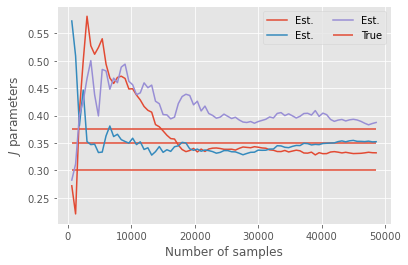

In [37]:
plt.plot(cum_shots, est_hist, label='Est.')
plt.hlines(true_params, np.amin(cum_shots), np.amax(cum_shots), label='True')
plt.legend(ncol=2)
plt.xlabel('Number of samples')
plt.ylabel(r'$J$ parameters')

In [38]:
updater.est_mean()

array([0.33207002, 0.35232641, 0.38743529])

Not bad really! But the estimation in Jzx is slightly off

# 3. CR Hamiltonian

In [39]:
from bayesianhl.qinfer_cr_hamiltonians import CRHamiltonian

## 3.1 Multiple shots, one expt at a time

In [40]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

sys_model = BinomialModel(CRHamiltonian(xi_J=xi_J, xi_t=xi_t))

In [41]:
# Define the true parameters
J_truth = np.array([[-4610290.4944338, -1479956.7612268,  -229800.80519662,
                    6608520.58971551,  1460516.49322424,   336451.01484356]])

# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [42]:
# Note that we have all components within [-10,10]
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])

In [43]:
# Lets try this with an estimator
Jmin = -10
Jmax = 10
n_particles = 10000

prior = UniformDistribution([[Jmin, Jmax]]*n_J)
updater = SMCUpdater(sys_model, n_particles, prior)

In [44]:
# Define the experiments
tvec = np.linspace(1, 6, 81)
mvec = [0, 1, 2]
uvec = [0, 1]

n_shots = 100

In [45]:
# Multiple shots at each (M, U, t)
est_hist = []
cum_shots = []

cum_shots_counter = 0
for t in tvec:
    for m in mvec:
        for u in uvec:
            experiment = np.array([(m, u, t, n_shots)], dtype=sys_model.expparams_dtype)
            outcomes = sys_model.simulate_experiment(J_truth_nd, experiment)
            updater.update(outcomes, experiment)
            
            cum_shots_counter += n_shots
    
            print('Done with (m,u,t) = (%d, %d, %f)' %(m, u, t))
    
    est_hist.append(updater.est_mean())
    cum_shots.append(cum_shots_counter)

/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if __name__ == '__main__':
/Users/arkopal/miniconda3/envs/active-qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 10000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done with (m,u,t) = (0, 0, 1.000000)
Done with (m,u,t) = (0, 1, 1.000000)
Done with (m,u,t) = (1, 0, 1.000000)
Done with (m,u,t) = (1, 1, 1.000000)
Done with (m,u,t) = (2, 0, 1.000000)
Done with (m,u,t) = (2, 1, 1.000000)
Done with (m,u,t) = (0, 0, 1.062500)
Done with (m,u,t) = (0, 1, 1.062500)
Done with (m,u,t) = (1, 0, 1.062500)
Done with (m,u,t) = (1, 1, 1.062500)
Done with (m,u,t) = (2, 0, 1.062500)
Done with (m,u,t) = (2, 1, 1.062500)
Done with (m,u,t) = (0, 0, 1.125000)
Done with (m,u,t) = (0, 1, 1.125000)
Done with (m,u,t) = (1, 0, 1.125000)
Done with (m,u,t) = (1, 1, 1.125000)
Done with (m,u,t) = (2, 0, 1.125000)
Done with (m,u,t) = (2, 1, 1.125000)
Done with (m,u,t) = (0, 0, 1.187500)
Done with (m,u,t) = (0, 1, 1.187500)
Done with (m,u,t) = (1, 0, 1.187500)
Done with (m,u,t) = (1, 1, 1.187500)
Done with (m,u,t) = (2, 0, 1.187500)
Done with (m,u,t) = (2, 1, 1.187500)
Done with (m,u,t) = (0, 0, 1.250000)
Done with (m,u,t) = (0, 1, 1.250000)
Done with (m,u,t) = (1, 0, 1.250000)
D

Done with (m,u,t) = (1, 1, 3.312500)
Done with (m,u,t) = (2, 0, 3.312500)
Done with (m,u,t) = (2, 1, 3.312500)
Done with (m,u,t) = (0, 0, 3.375000)
Done with (m,u,t) = (0, 1, 3.375000)
Done with (m,u,t) = (1, 0, 3.375000)
Done with (m,u,t) = (1, 1, 3.375000)
Done with (m,u,t) = (2, 0, 3.375000)
Done with (m,u,t) = (2, 1, 3.375000)
Done with (m,u,t) = (0, 0, 3.437500)
Done with (m,u,t) = (0, 1, 3.437500)
Done with (m,u,t) = (1, 0, 3.437500)
Done with (m,u,t) = (1, 1, 3.437500)
Done with (m,u,t) = (2, 0, 3.437500)
Done with (m,u,t) = (2, 1, 3.437500)
Done with (m,u,t) = (0, 0, 3.500000)
Done with (m,u,t) = (0, 1, 3.500000)
Done with (m,u,t) = (1, 0, 3.500000)
Done with (m,u,t) = (1, 1, 3.500000)
Done with (m,u,t) = (2, 0, 3.500000)
Done with (m,u,t) = (2, 1, 3.500000)
Done with (m,u,t) = (0, 0, 3.562500)
Done with (m,u,t) = (0, 1, 3.562500)
Done with (m,u,t) = (1, 0, 3.562500)
Done with (m,u,t) = (1, 1, 3.562500)
Done with (m,u,t) = (2, 0, 3.562500)
Done with (m,u,t) = (2, 1, 3.562500)
D

RuntimeError: All particle weights are zero.

In [ ]:
# 10000 particles
plt.plot(cum_shots, est_hist, label='Est.')
plt.hlines(J_truth_nd, np.amin(cum_shots), np.amax(cum_shots), label='True')
plt.legend(ncol=2)
plt.xlabel('Number of samples')
plt.ylabel(r'$J$ parameters')

Text(0, 0.5, '$J$ parameters')

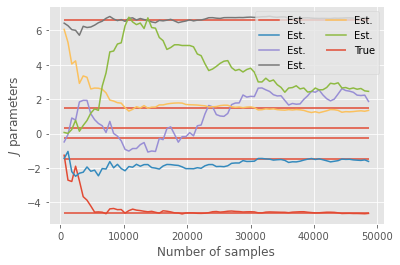

In [42]:
# 5000 particles
plt.plot(cum_shots, est_hist, label='Est.')
plt.hlines(J_truth_nd, np.amin(cum_shots), np.amax(cum_shots), label='True')
plt.legend(ncol=2)
plt.xlabel('Number of samples')
plt.ylabel(r'$J$ parameters')

In [60]:
updater.est_mean()

array([-4.62693928, -1.55770338, -0.05670002,  6.58558695,  1.46437942,
        0.23827158])

In [61]:
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])

# 5. Noisy CR Hamiltonian

In [17]:
from bayesianhl.qinfer_cr_hamiltonians import NoisyCRHamiltonian

In [18]:
# Define quantum system model
n_J = 6
xi_J = 1e6*np.ones((n_J,))
xi_t = 1e-7

sys_model = BinomialModel(NoisyCRHamiltonian(xi_J=xi_J, xi_t=xi_t, FLAG_control_noise=True))

In [19]:
# Define the true parameters
J_truth = np.array([[-4610290.4944338, -1479956.7612268,  -229800.80519662,
                    6608520.58971551,  1460516.49322424,   336451.01484356]])

# This is what we will actually run with -- non-dimensional parameters 
J_truth_nd = J_truth/xi_J

In [20]:
# Note that we have all components within [-10,10]
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])

In [21]:
# Lets try this with an estimator
Jmin = -10
Jmax = 10
n_particles = 5000

prior = UniformDistribution([[Jmin, Jmax]]*n_J)
updater = SMCUpdater(sys_model, n_particles, prior)

In [22]:
# Define the experiments
tvec = np.linspace(1, 6, 81)
mvec = [0, 1, 2]
uvec = [0, 1]

n_shots = 100

In [23]:
# Multiple shots at each (M, U, t)
est_hist = []
cum_shots = []

cum_shots_counter = 0
for t in tvec:
    for m in mvec:
        for u in uvec:
            experiment = np.array([(m, u, t, n_shots)], dtype=sys_model.expparams_dtype)
            outcomes = sys_model.simulate_experiment(J_truth_nd, experiment)
            updater.update(outcomes, experiment)
            
            cum_shots_counter += n_shots
    
            print('Done with (m,u,t) = (%d, %d, %f)' %(m, u, t))
    
    est_hist.append(updater.est_mean())
    cum_shots.append(cum_shots_counter)

/Users/arkopal/miniconda3/envs/qinfer-hl-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if __name__ == '__main__':
/Users/arkopal/miniconda3/envs/qinfer-hl-env/lib/python3.6/site-packages/qinfer/resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5000 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Done with (m,u,t) = (0, 0, 1.000000)
Done with (m,u,t) = (0, 1, 1.000000)
Done with (m,u,t) = (1, 0, 1.000000)
Done with (m,u,t) = (1, 1, 1.000000)
Done with (m,u,t) = (2, 0, 1.000000)
Done with (m,u,t) = (2, 1, 1.000000)
Done with (m,u,t) = (0, 0, 1.062500)
Done with (m,u,t) = (0, 1, 1.062500)
Done with (m,u,t) = (1, 0, 1.062500)
Done with (m,u,t) = (1, 1, 1.062500)
Done with (m,u,t) = (2, 0, 1.062500)
Done with (m,u,t) = (2, 1, 1.062500)
Done with (m,u,t) = (0, 0, 1.125000)
Done with (m,u,t) = (0, 1, 1.125000)
Done with (m,u,t) = (1, 0, 1.125000)
Done with (m,u,t) = (1, 1, 1.125000)
Done with (m,u,t) = (2, 0, 1.125000)
Done with (m,u,t) = (2, 1, 1.125000)
Done with (m,u,t) = (0, 0, 1.187500)
Done with (m,u,t) = (0, 1, 1.187500)
Done with (m,u,t) = (1, 0, 1.187500)
Done with (m,u,t) = (1, 1, 1.187500)
Done with (m,u,t) = (2, 0, 1.187500)
Done with (m,u,t) = (2, 1, 1.187500)
Done with (m,u,t) = (0, 0, 1.250000)
Done with (m,u,t) = (0, 1, 1.250000)
Done with (m,u,t) = (1, 0, 1.250000)
D

Done with (m,u,t) = (0, 0, 3.312500)
Done with (m,u,t) = (0, 1, 3.312500)
Done with (m,u,t) = (1, 0, 3.312500)
Done with (m,u,t) = (1, 1, 3.312500)
Done with (m,u,t) = (2, 0, 3.312500)
Done with (m,u,t) = (2, 1, 3.312500)
Done with (m,u,t) = (0, 0, 3.375000)
Done with (m,u,t) = (0, 1, 3.375000)
Done with (m,u,t) = (1, 0, 3.375000)
Done with (m,u,t) = (1, 1, 3.375000)
Done with (m,u,t) = (2, 0, 3.375000)
Done with (m,u,t) = (2, 1, 3.375000)
Done with (m,u,t) = (0, 0, 3.437500)
Done with (m,u,t) = (0, 1, 3.437500)
Done with (m,u,t) = (1, 0, 3.437500)
Done with (m,u,t) = (1, 1, 3.437500)
Done with (m,u,t) = (2, 0, 3.437500)
Done with (m,u,t) = (2, 1, 3.437500)
Done with (m,u,t) = (0, 0, 3.500000)
Done with (m,u,t) = (0, 1, 3.500000)
Done with (m,u,t) = (1, 0, 3.500000)
Done with (m,u,t) = (1, 1, 3.500000)
Done with (m,u,t) = (2, 0, 3.500000)
Done with (m,u,t) = (2, 1, 3.500000)
Done with (m,u,t) = (0, 0, 3.562500)
Done with (m,u,t) = (0, 1, 3.562500)
Done with (m,u,t) = (1, 0, 3.562500)
D

Done with (m,u,t) = (1, 0, 5.812500)
Done with (m,u,t) = (1, 1, 5.812500)
Done with (m,u,t) = (2, 0, 5.812500)
Done with (m,u,t) = (2, 1, 5.812500)
Done with (m,u,t) = (0, 0, 5.875000)
Done with (m,u,t) = (0, 1, 5.875000)
Done with (m,u,t) = (1, 0, 5.875000)
Done with (m,u,t) = (1, 1, 5.875000)
Done with (m,u,t) = (2, 0, 5.875000)
Done with (m,u,t) = (2, 1, 5.875000)
Done with (m,u,t) = (0, 0, 5.937500)
Done with (m,u,t) = (0, 1, 5.937500)
Done with (m,u,t) = (1, 0, 5.937500)
Done with (m,u,t) = (1, 1, 5.937500)
Done with (m,u,t) = (2, 0, 5.937500)
Done with (m,u,t) = (2, 1, 5.937500)
Done with (m,u,t) = (0, 0, 6.000000)
Done with (m,u,t) = (0, 1, 6.000000)
Done with (m,u,t) = (1, 0, 6.000000)
Done with (m,u,t) = (1, 1, 6.000000)
Done with (m,u,t) = (2, 0, 6.000000)
Done with (m,u,t) = (2, 1, 6.000000)


Text(0, 0.5, '$J$ parameters')

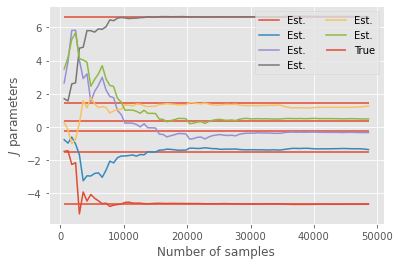

In [24]:
# 5000 particles
plt.plot(cum_shots, est_hist, label='Est.')
plt.hlines(J_truth_nd, np.amin(cum_shots), np.amax(cum_shots), label='True')
plt.legend(ncol=2)
plt.xlabel('Number of samples')
plt.ylabel(r'$J$ parameters')

In [25]:
updater.est_mean()

array([-4.63366018, -1.35717005, -0.3305823 ,  6.640379  ,  1.26715873,
        0.4891988 ])

In [26]:
J_truth_nd

array([[-4.61029049, -1.47995676, -0.22980081,  6.60852059,  1.46051649,
         0.33645101]])